In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")
np.random.seed(42)


In [3]:

n = 1000

data = {
    "gender": np.random.choice(["Male", "Female"], size=n, p=[0.6, 0.4]),
    "age": np.random.randint(21, 60, size=n),
    "income": np.random.randint(20000, 100000, size=n),
}

df = pd.DataFrame(data)

# Create biased model predictions
df["actual_outcome"] = (
    (df["income"] > 50000) & (df["age"] < 50)
).astype(int)

# Inject bias: females slightly less likely to get positive prediction
df["model_prediction"] = df["actual_outcome"]

bias_mask = (df["gender"] == "Female") & (df["model_prediction"] == 1)
df.loc[bias_mask, "model_prediction"] = np.random.choice(
    [0, 1], size=bias_mask.sum(), p=[0.3, 0.7]
)

df.head()


,gender,age,income,actual_outcome,model_prediction
0,Male,32,61991,1,1
1,Female,36,90476,1,1
2,Female,44,80920,1,0
3,Male,39,83530,1,1
4,Male,28,56224,1,1


In [4]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1000 non-null   object
 1   age               1000 non-null   int64 
 2   income            1000 non-null   int64 
 3   actual_outcome    1000 non-null   int64 
 4   model_prediction  1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


gender              0
age                 0
income              0
actual_outcome      0
model_prediction    0
dtype: int64

In [5]:
SENSITIVE_ATTR = "gender"
LABEL = "actual_outcome"
PRED = "model_prediction"


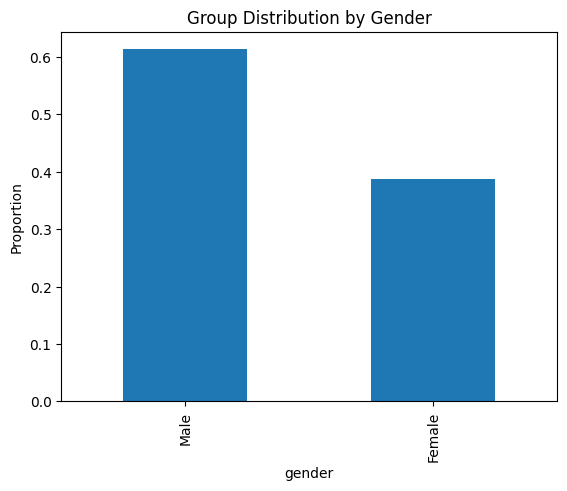

In [6]:
group_distribution = df[SENSITIVE_ATTR].value_counts(normalize=True)
group_distribution
group_distribution.plot(kind="bar")
plt.title("Group Distribution by Gender")
plt.ylabel("Proportion")
plt.show()


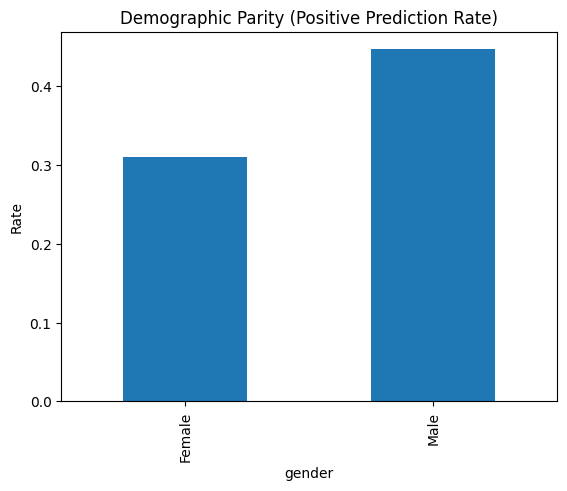

In [7]:
def demographic_parity(df, group_col, pred_col):
    return df.groupby(group_col)[pred_col].mean()

dp = demographic_parity(df, SENSITIVE_ATTR, PRED)
dp
dp.plot(kind="bar")
plt.title("Demographic Parity (Positive Prediction Rate)")
plt.ylabel("Rate")
plt.show()


In [8]:
disparate_impact = dp.min() / dp.max()
disparate_impact


np.float64(0.6937135743789962)

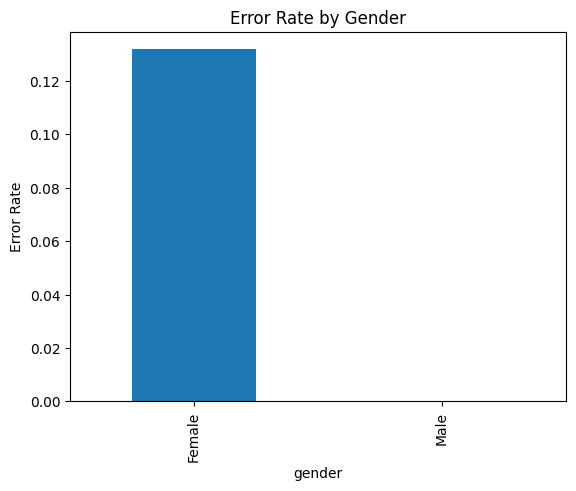

In [9]:
df["error"] = (df[LABEL] != df[PRED]).astype(int)

error_rates = df.groupby(SENSITIVE_ATTR)["error"].mean()
error_rates
error_rates.plot(kind="bar")
plt.title("Error Rate by Gender")
plt.ylabel("Error Rate")
plt.show()


In [10]:
def confusion_metrics(df, group):
    subset = df[df[SENSITIVE_ATTR] == group]
    tp = ((subset[PRED] == 1) & (subset[LABEL] == 1)).sum()
    fp = ((subset[PRED] == 1) & (subset[LABEL] == 0)).sum()
    fn = ((subset[PRED] == 0) & (subset[LABEL] == 1)).sum()
    tn = ((subset[PRED] == 0) & (subset[LABEL] == 0)).sum()
    return tp, fp, fn, tn

for g in df[SENSITIVE_ATTR].unique():
    print(g, confusion_metrics(df, g))


Male (np.int64(274), np.int64(0), np.int64(0), np.int64(339))
Female (np.int64(120), np.int64(0), np.int64(51), np.int64(216))


In [11]:
summary = pd.DataFrame({
    "Positive_Prediction_Rate": dp,
    "Error_Rate": error_rates
})

summary


,Positive_Prediction_Rate,Error_Rate
gender,,
Female,0.310078,0.131783
Male,0.446982,0.000000
